## Player Types:

- `default`: An AI agent initialized with a zero-shot prompt. Just the gave description.
- `spp`: Solo Performance Prompting; an AI agent initialized with the SPP prompt.
- `cot`: Chain-of-Thought; an AI agent initialized with the COT prompt.
- `srep`: Singe-Round-Equilibrium-Player; a player who strictly follows the Single Round Equilibrium Strategy (a specific probability distribution over the available moves)
- `pp`: Pattern Player; Follows a cyclic pattern of moves. Always playes moves from this pattern.
- `ap`: Adaptive Player; finds the most frequent move their opponent plays and counters it.
- `tft`: Tit-for-Tat Player; counters opponent's last played move.

## ToT experiments:

- We compare an AI agent in a ToT environment vs all other agents. If the opponent is also an AI agent, then the opponent in **NOT** a ToT player.
- ToT: Each time the AI agent has to play. They generate 5 different answers. We then choose the most frequent result and choose an answer that gave that result. We continue with this history for the rest of the game (as many rounds as it is). Conficts are resolved at random and/or by choosing the first answer that gave the result we picked.

In [ ]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

In [ ]:
models = [
    {
        "id" : "anthropic.claude-3-5-sonnet-20241022-v2:0",
        "name" : "Claude 3.5 Sonnet v2",
        "thinking" : False,
    },
    {
        "id" : "us.anthropic.claude-3-7-sonnet-20250219-v1:0",
        "name" : "Claude 3.7 Sonnet",
        "thinking" : False,
    },
    {
        "id" : "us.anthropic.claude-3-7-sonnet-20250219-v1:0",
        "name" : "Claude 3.7 Sonnet (Thinking)",
        "thinking" : True,
    },
    {
        "id" : "us.anthropic.claude-sonnet-4-20250514-v1:0",
        "name" : "Claude Sonnet 4",
        "thinking" : False,
    },
    {
        "id" : "us.anthropic.claude-sonnet-4-20250514-v1:0",
        "name" : "Claude Sonnet 4 (Thinking)",
        "thinking" : True,
    },
    {
        "id" : "us.meta.llama3-3-70b-instruct-v1:0",
        "name" : "Llama 3.3 70B Instruct",
        "thinking" : False,
    },
    {
        "id" : "mistral.mistral-large-2407-v1:0",
        "name" : "Mistral Large (24.07)",
        "thinking" : False,
    },
    {
        "id" : "us.deepseek.r1-v1:0",
        "name" : "DeepSeek-R1",
        "thinking" : False,
    },
]

In [ ]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def plot_average_results(
    player_type: str,
    log_dir: str,
    model_name: str,
    game_type: str,
    game_settings_type: str,
    ax: plt.Axes,
    iteration_cnt : int,
    tot : bool = False,
):
    y_replacements = {
        "default": "zs",
    } if not tot else {
        "default": "sc-zs",
        "spp": "sc-spp",
        "cot": "sc-cot",
    }
    x_replacements = {
        "default": "zs",
    }
    # Structure to collect data per opponent type
    data = defaultdict(lambda: {'win': [], 'loss': [], 'tie': []})

    opponent_types = list()

    for itr in range(iteration_cnt):
        directory = os.path.join(log_dir, f"iteration_{itr}", model_name, game_type, game_settings_type)

        if not os.path.isdir(directory):
            continue

        for dir in sorted(
            os.listdir(directory),
            #key=lambda x: int(x.split('_')[-1])
        ):
            info_path = os.path.join(directory, dir, 'game.json')
            if not os.path.isfile(info_path):
                continue

            with open(info_path) as f:
                info = json.load(f)

            player_types = [info.get(f"player_{i}_player_type") for i in range(2)]
            if player_type not in player_types:
                continue

            player_idx = player_types.index(player_type)

            if player_idx != 0 and tot:
                continue
            
            opponent_type = player_types[1 - player_idx]

            if opponent_type not in opponent_types:
                opponent_types.append(opponent_type)

            rates = info.get(f"player_{player_idx}_rates")

            if rates is None:
                raise ValueError(f"Empty rates for player {player_type} in {info_path}")

            for key in ['win', 'loss', 'tie']:
                data[opponent_type][key].append(rates.get(key, 0))

    # sort opponent types for consistent ordering
    opponent_types_aux = ["default", "spp", "cot", "srep", "pp", "ap", "tft"]
    opponent_types = [opp for opp in opponent_types_aux if opp in opponent_types]

    # Consistent ordering of opponent types
    n_opponents = len(opponent_types)
    x = np.arange(n_opponents)
    total_bar_width = 0.8
    bar_width = total_bar_width / iteration_cnt

    # Plot bars for each iteration
    for i in range(iteration_cnt):
        wins = [data[opp]['win'][i] if i < len(data[opp]['win']) else 0 for opp in opponent_types]
        losses = [data[opp]['loss'][i] if i < len(data[opp]['loss']) else 0 for opp in opponent_types]
        ties = [data[opp]['tie'][i] if i < len(data[opp]['tie']) else 0 for opp in opponent_types]

        offsets = x - total_bar_width/2 + i * bar_width

        # Only add legend labels in first iteration
        win_label = 'win' if i == 0 else ""
        loss_label = 'loss' if i == 0 else ""
        tie_label = 'tie' if i == 0 else ""

        ax.bar(offsets, wins, bar_width, label=win_label, color='tab:blue')
        ax.bar(offsets, losses, bar_width, bottom=wins, label=loss_label, color='tab:orange')
        tie_bottom = [w + l for w, l in zip(wins, losses)]
        ax.bar(offsets, ties, bar_width, bottom=tie_bottom, label=tie_label, color='tab:green')

    player_type_title = player_type
    for old, new in y_replacements.items():
        player_type_title = player_type_title.replace(old, new)
    ax.set_title(
        f"Performance of \"{player_type_title}\" per Opponent (24 rounds per opponent)\n"
        f"Model: {model_name}, Game: {game_type}, Settings: {game_settings_type}",
        fontsize=11
    )

    ax.set_xlabel("Opponent player type", fontsize=10)
    ax.set_ylabel("Outcome rate (win/loss/tie)", fontsize=10)

    x_labels = opponent_types
    for old, new in x_replacements.items():
        x_labels = [label.replace(old, new) for label in x_labels]
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    
    ax.legend(title="Game result", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, title_fontsize=10)

    ax.text(
        1.0, -0.15,
        f"Each group shows {iteration_cnt} runs per opponent",
        transform=ax.transAxes,
        fontsize=8,
        ha='right'
    )



In [ ]:
def plot_average_results_of_group(player_type : str, log_source : str, iteration_cnt : int, tot : bool = False):
    fig, axs = plt.subplots(len(models), 4, figsize=(32, 16))
    axs = axs.flatten()

    i = 0
    for model_name in [model["name"] for model in models]:
        for game_settings_type in ["eq1", "ba3", "eq1-alt", "ba3-alt"]:
            plot_average_results(player_type, log_source, model_name, "rps", game_settings_type, axs[i], iteration_cnt, tot)
            i += 1

    plt.tight_layout()

In [ ]:
plot_average_results_of_group("default", "../logs/logs_3/data", 5)

In [ ]:
plot_average_results_of_group("spp", "../logs/logs_3/data", 5)

In [ ]:
plot_average_results_of_group("cot", "../logs/logs_3/data", 5)

In [ ]:
plot_average_results_of_group("default", "../logs/logs_3/data_tot", 2, True)

In [ ]:
plot_average_results_of_group("spp", "../logs/logs_3/data_tot", 2, True)

In [ ]:
plot_average_results_of_group("cot", "../logs/logs_3/data_tot", 2, True)

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_total_points(
    player_type: str,
    log_dir: str,
    model_name: str,
    game_type: str,
    game_settings_type: str,
    ax: plt.Axes,
    iteration_cnt: int,
    tot: bool = False,
):
    y_replacements = {
        "default": "zs",
    } if not tot else {
        "default": "sc-zs",
        "spp": "sc-spp",
        "cot": "sc-cot",
    }
    x_replacements = {
        "default": "zs",
    }

    data = defaultdict(list)
    opponent_types = []

    # Collect total points per run for each opponent
    for itr in range(iteration_cnt):
        directory = os.path.join(log_dir, f"iteration_{itr}", model_name, game_type, game_settings_type)

        if not os.path.isdir(directory):
            continue

        for dir in sorted(
            os.listdir(directory),
            #key=lambda x: int(x.split('_')[-1])
        ):
            info_path = os.path.join(directory, dir, 'game.json')
            if not os.path.isfile(info_path):
                continue

            with open(info_path) as f:
                info = json.load(f)

            player_types = [info.get(f"player_{i}_player_type") for i in range(2)]
            if player_type not in player_types:
                continue

            player_idx = player_types.index(player_type)

            if player_idx != 0 and tot:
                continue

            opponent_type = player_types[1 - player_idx]

            if opponent_type not in opponent_types:
                opponent_types.append(opponent_type)

            total_points = info.get(f"player_{player_idx}_total_points")
            
            if total_points is None:
                raise ValueError(f"Empty total points for player {player_type} in {info_path}")

            data[opponent_type].append(total_points)

    # Sort opponents for consistent x-axis
    opponent_types_aux = ["default", "spp", "cot", "srep", "pp", "ap", "tft"]
    opponent_types = [opp for opp in opponent_types_aux if opp in opponent_types]
    
    x_positions = np.arange(len(opponent_types))

    # Jittered scatter plot (strip plot)
    for i, opponent in enumerate(opponent_types):
        y_values = data[opponent]
        x_jitter = np.random.normal(loc=0, scale=0.05, size=len(y_values))  # slight horizontal jitter
        ax.scatter(x_positions[i] + x_jitter, y_values, alpha=0.7, label=opponent)

    # Mean line
    for i, opponent in enumerate(opponent_types):
        y_values = data[opponent]
        mean = np.mean(y_values)
        ax.hlines(mean, x_positions[i] - 0.2, x_positions[i] + 0.2, color='black', linewidth=2)

    player_type_title = player_type
    for old, new in y_replacements.items():
        player_type_title = player_type_title.replace(old, new)
    ax.set_title(
        f"Total Points for \"{player_type_title}\" per Opponent (24 rounds per opponent) \n"
        f"Model: {model_name}, Game: {game_type}, Settings: {game_settings_type}",
        fontsize=11
    )

    ax.set_xlabel("Opponent player type", fontsize=10)
    ax.set_ylabel("Total Points", fontsize=10)

    x_labels = opponent_types
    for old, new in x_replacements.items():
        x_labels = [label.replace(old, new) for label in x_labels]
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')

    ax.grid(True, linestyle='--', alpha=0.3)

    ax.text(
        1.0, -0.15,
        f"{iteration_cnt} runs per opponent",
        transform=ax.transAxes,
        fontsize=8,
        ha='right'
    )


In [ ]:
def plot_total_points_of_group(player_type : str, log_source : str, iteration_cnt : int, tot : bool = False):
    fig, axs = plt.subplots(len(models), 4, figsize=(32, 16))
    axs = axs.flatten()

    i = 0
    for model_name in [model["name"] for model in models]:
        for game_settings_type in ["eq1", "ba3", "eq1-alt", "ba3-alt"]:
            plot_total_points(player_type, log_source, model_name, "rps", game_settings_type, axs[i], iteration_cnt, tot)
            i += 1

    plt.tight_layout()

In [ ]:
plot_total_points_of_group("default", "../logs/logs_3/data", 5)

In [ ]:
plot_total_points_of_group("spp", "../logs/logs_3/data", 5)

In [ ]:
plot_total_points_of_group("cot", "../logs/logs_3/data", 5)

In [ ]:
plot_total_points_of_group("default", "../logs/logs_3/data_tot", 2, True)

In [ ]:
plot_total_points_of_group("spp", "../logs/logs_3/data_tot", 2, True)

In [ ]:
plot_total_points_of_group("cot", "../logs/logs_3/data_tot", 2, True)

In [ ]:
def plot_cumulative_results(
    player_type: str,
    log_dir: str,
    model_name: str,
    game_type: str,
    game_settings_type: str,
    ax: plt.Axes,
    tot: bool = False,
):
    y_replacements = {
        "default": "zs",
    } if not tot else {
        "default": "sc-zs",
        "spp": "sc-spp",
        "cot": "sc-cot",
    }
    x_replacements = {
        "default": "zs",
    }

    directory = os.path.join(log_dir, model_name, game_type, game_settings_type)

    # Structure: opponent_type -> {'win': [..], 'loss': [..], 'tie': [..]} (each list of length 6 for 6 segments)
    data = defaultdict(lambda: {'win': [], 'loss': [], 'tie': []})
    opponent_types = []

    for dir in sorted(
        os.listdir(directory),
        #key=lambda x: int(x.split('_')[-1]),
        ):
        info_path = os.path.join(directory, dir, 'game.json')
        if not os.path.isfile(info_path):
            continue

        with open(info_path) as f:
            info = json.load(f)

        player_types = [info.get(f"player_{i}_player_type") for i in range(2)]
        if player_type not in player_types:
            continue

        player_idx = player_types.index(player_type)

        if player_idx != 0 and tot:
            continue
        
        opponent_type = player_types[1 - player_idx]

        if opponent_type not in opponent_types:
            opponent_types.append(opponent_type)

        points = info.get(f"player_{player_idx}_points")
        
        if points is None:
            raise ValueError(f"Empty points for player {player_type} in {info_path}")

        # Collect cumulative outcome rates every 4 rounds
        for i in range(4, len(points) + 1, 4):
            segment = points[:i]
            total = len(segment)

            wins = sum(1 for p in segment if p > 0)
            losses = sum(1 for p in segment if p < 0)
            ties = sum(1 for p in segment if p == 0)

            data[opponent_type]['win'].append(wins / total)
            data[opponent_type]['loss'].append(losses / total)
            data[opponent_type]['tie'].append(ties / total)

    # Sort opponent types for consistent ordering
    opponent_types_aux = ["default", "spp", "cot", "srep", "pp", "ap", "tft"]
    opponent_types = [opp for opp in opponent_types_aux if opp in opponent_types]

    # Number of rounds per opponent
    rounds_per_opponent = 24 // 4 # Assuming 24 rounds total, with segments every 4 rounds
    n_opponents = len(opponent_types)
    x = np.arange(n_opponents)
    total_bar_width = 0.8
    bar_width = total_bar_width / rounds_per_opponent

    # Plot bars for each round segment (like iterations)
    for i in range(rounds_per_opponent):
        wins = [data[opp]['win'][i] if i < len(data[opp]['win']) else 0 for opp in opponent_types]
        losses = [data[opp]['loss'][i] if i < len(data[opp]['loss']) else 0 for opp in opponent_types]
        ties = [data[opp]['tie'][i] if i < len(data[opp]['tie']) else 0 for opp in opponent_types]

        offsets = x - total_bar_width / 2 + i * bar_width

        # Only label the first group with legend entries
        win_label = 'win' if i == 0 else ""
        loss_label = 'loss' if i == 0 else ""
        tie_label = 'tie' if i == 0 else ""

        ax.bar(offsets, wins, bar_width, label=win_label, color='tab:blue')
        ax.bar(offsets, losses, bar_width, bottom=wins, label=loss_label, color='tab:orange')
        tie_bottom = [w + l for w, l in zip(wins, losses)]
        ax.bar(offsets, ties, bar_width, bottom=tie_bottom, label=tie_label, color='tab:green')

    # Axis and legend setup
    player_type_title = player_type
    for old, new in y_replacements.items():
        player_type_title = player_type_title.replace(old, new)
    ax.set_title(
        f"Performance of \"{player_type_title}\" against various opponents (cumulative every 4 rounds)\n"
        f"Model: {model_name}, Game: {game_type}, Settings: {game_settings_type}",
        fontsize=11
    )
    ax.set_xlabel("Opponent player type", fontsize=10)
    ax.set_ylabel("Outcome rate (win/loss/tie)", fontsize=10)

    x_labels = opponent_types
    for old, new in x_replacements.items():
        x_labels = [label.replace(old, new) for label in x_labels]
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')

    ax.legend(title="Game result", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, title_fontsize=10)

    ax.text(
        1.0, -0.15,
        "Each group shows cumulative results at rounds 4, 8, ..., 24",
        transform=ax.transAxes,
        fontsize=8,
        ha='right'
    )


In [ ]:
def plot_cumulative_results_of_group(player_type : str, log_source : str, tot : bool = False):
    fig, axs = plt.subplots(len(models), 4, figsize=(32, 16))
    axs = axs.flatten()

    i = 0
    for model_name in [model["name"] for model in models]:
        for game_settings_type in ["eq1", "ba3", "eq1-alt", "ba3-alt"]:
            plot_cumulative_results(player_type, log_source, model_name, "rps", game_settings_type, axs[i], tot)
            i += 1
    
    plt.tight_layout()

In [ ]:
plot_cumulative_results_of_group("default", "../logs/logs_3/data/iteration_1")

In [ ]:
plot_cumulative_results_of_group("spp", "../logs/logs_3/data/iteration_1")

In [ ]:
plot_cumulative_results_of_group("cot", "../logs/logs_3/data/iteration_1")

In [ ]:
plot_cumulative_results_of_group("default", "../logs/logs_3/data_tot/iteration_1", True)

In [ ]:
plot_cumulative_results_of_group("spp", "../logs/logs_3/data_tot/iteration_1", True)

In [ ]:
plot_cumulative_results_of_group("cot", "../logs/logs_3/data_tot/iteration_1", True)

In [49]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_cumulative_points(
    player_type: str,
    log_dir: str,
    model_name: str,
    game_type: str,
    game_settings_type: str,
    ax: plt.Axes,
    tot: bool = False,
):
    y_replacements = {
        "default": "zs",
    } if not tot else {
        "default": "sc-zs",
        "spp": "sc-spp",
        "cot": "sc-cot",
    }
    x_replacements = {
        "default": "zs",
    }

    directory = os.path.join(log_dir, model_name, game_type, game_settings_type)

    # Structure: opponent_type -> list of cumulative point lists
    data = defaultdict(list)
    opponent_types = []

    for dir in sorted(
        os.listdir(directory),
        #key=lambda x: int(x.split('_')[-1]),
        ):
        info_path = os.path.join(directory, dir, 'game.json')
        if not os.path.isfile(info_path):
            continue

        with open(info_path) as f:
            info = json.load(f)

        player_types = [info.get(f"player_{i}_player_type") for i in range(2)]
        if player_type not in player_types:
            continue

        player_idx = player_types.index(player_type)

        if player_idx != 0 and tot:
            continue

        opponent_type = player_types[1 - player_idx]

        if opponent_type not in opponent_types:
            opponent_types.append(opponent_type)

        points = info.get(f"player_{player_idx}_points")
        
        if points is None:
            raise ValueError(f"Empty points for player {player_type} in {info_path}")

        # Compute cumulative sums in segments of 4
        cum_points = []
        for i in range(4, len(points) + 1, 4):
            segment_sum = sum(points[:i])
            cum_points.append(segment_sum)

        data[opponent_type].append(cum_points)

    # Plotting cumulative points for each opponent
    segment_count = max(len(seq) for runs in data.values() for seq in runs)
    x_segments = np.arange(4, 4 * segment_count + 1, 4)  # e.g., 4, 8, ..., 24

    # Sort opponent types for consistent ordering
    opponent_types_aux = ["default", "spp", "cot", "srep", "pp", "ap", "tft"]
    opponent_types = [opp for opp in opponent_types_aux if opp in opponent_types]

    for opponent in opponent_types:
        runs = data[opponent]
        opponent_label = opponent
        for old, new in x_replacements.items():
            opponent_label = opponent_label.replace(old, new)
        for run in runs:
            ax.plot(x_segments[:len(run)], run, alpha=0.6, label=opponent_label)

    # Legend: only unique opponent types
    handles, labels = ax.get_legend_handles_labels()
    unique = dict()
    for h, l in zip(handles, labels):
        if l not in unique:
            unique[l] = h
    ax.legend(unique.values(), unique.keys(), title="Opponent", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    player_type_title = player_type
    for old, new in y_replacements.items():
        player_type_title = player_type_title.replace(old, new)
    ax.set_title(
        f"Cumulative Points for \"{player_type_title}\" vs. Opponents\n"
        f"Model: {model_name}, Game: {game_type}, Settings: {game_settings_type}",
        fontsize=11
    )
    ax.set_xlabel("Round", fontsize=10)
    ax.set_ylabel("Cumulative Points", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.4)

    #ax.text(
    #    1.0, -0.15,
    #    "Each line is a separate run; segments are at rounds 4, 8, ..., 24",
    #    transform=ax.transAxes,
    #    fontsize=8,
    #    ha='right'
    #)


In [50]:
def plot_cumulative_points_of_group(player_type : str, log_source : str, tot : bool = False):
    fig, axs = plt.subplots(len(models), 4, figsize=(32, 16))
    axs = axs.flatten()

    i = 0
    for model_name in [model["name"] for model in models]:
        for game_settings_type in ["eq1", "ba3", "eq1-alt", "ba3-alt"]:
            plot_cumulative_points(player_type, log_source, model_name, "rps", game_settings_type, axs[i], tot)
            i += 1

    plt.tight_layout()

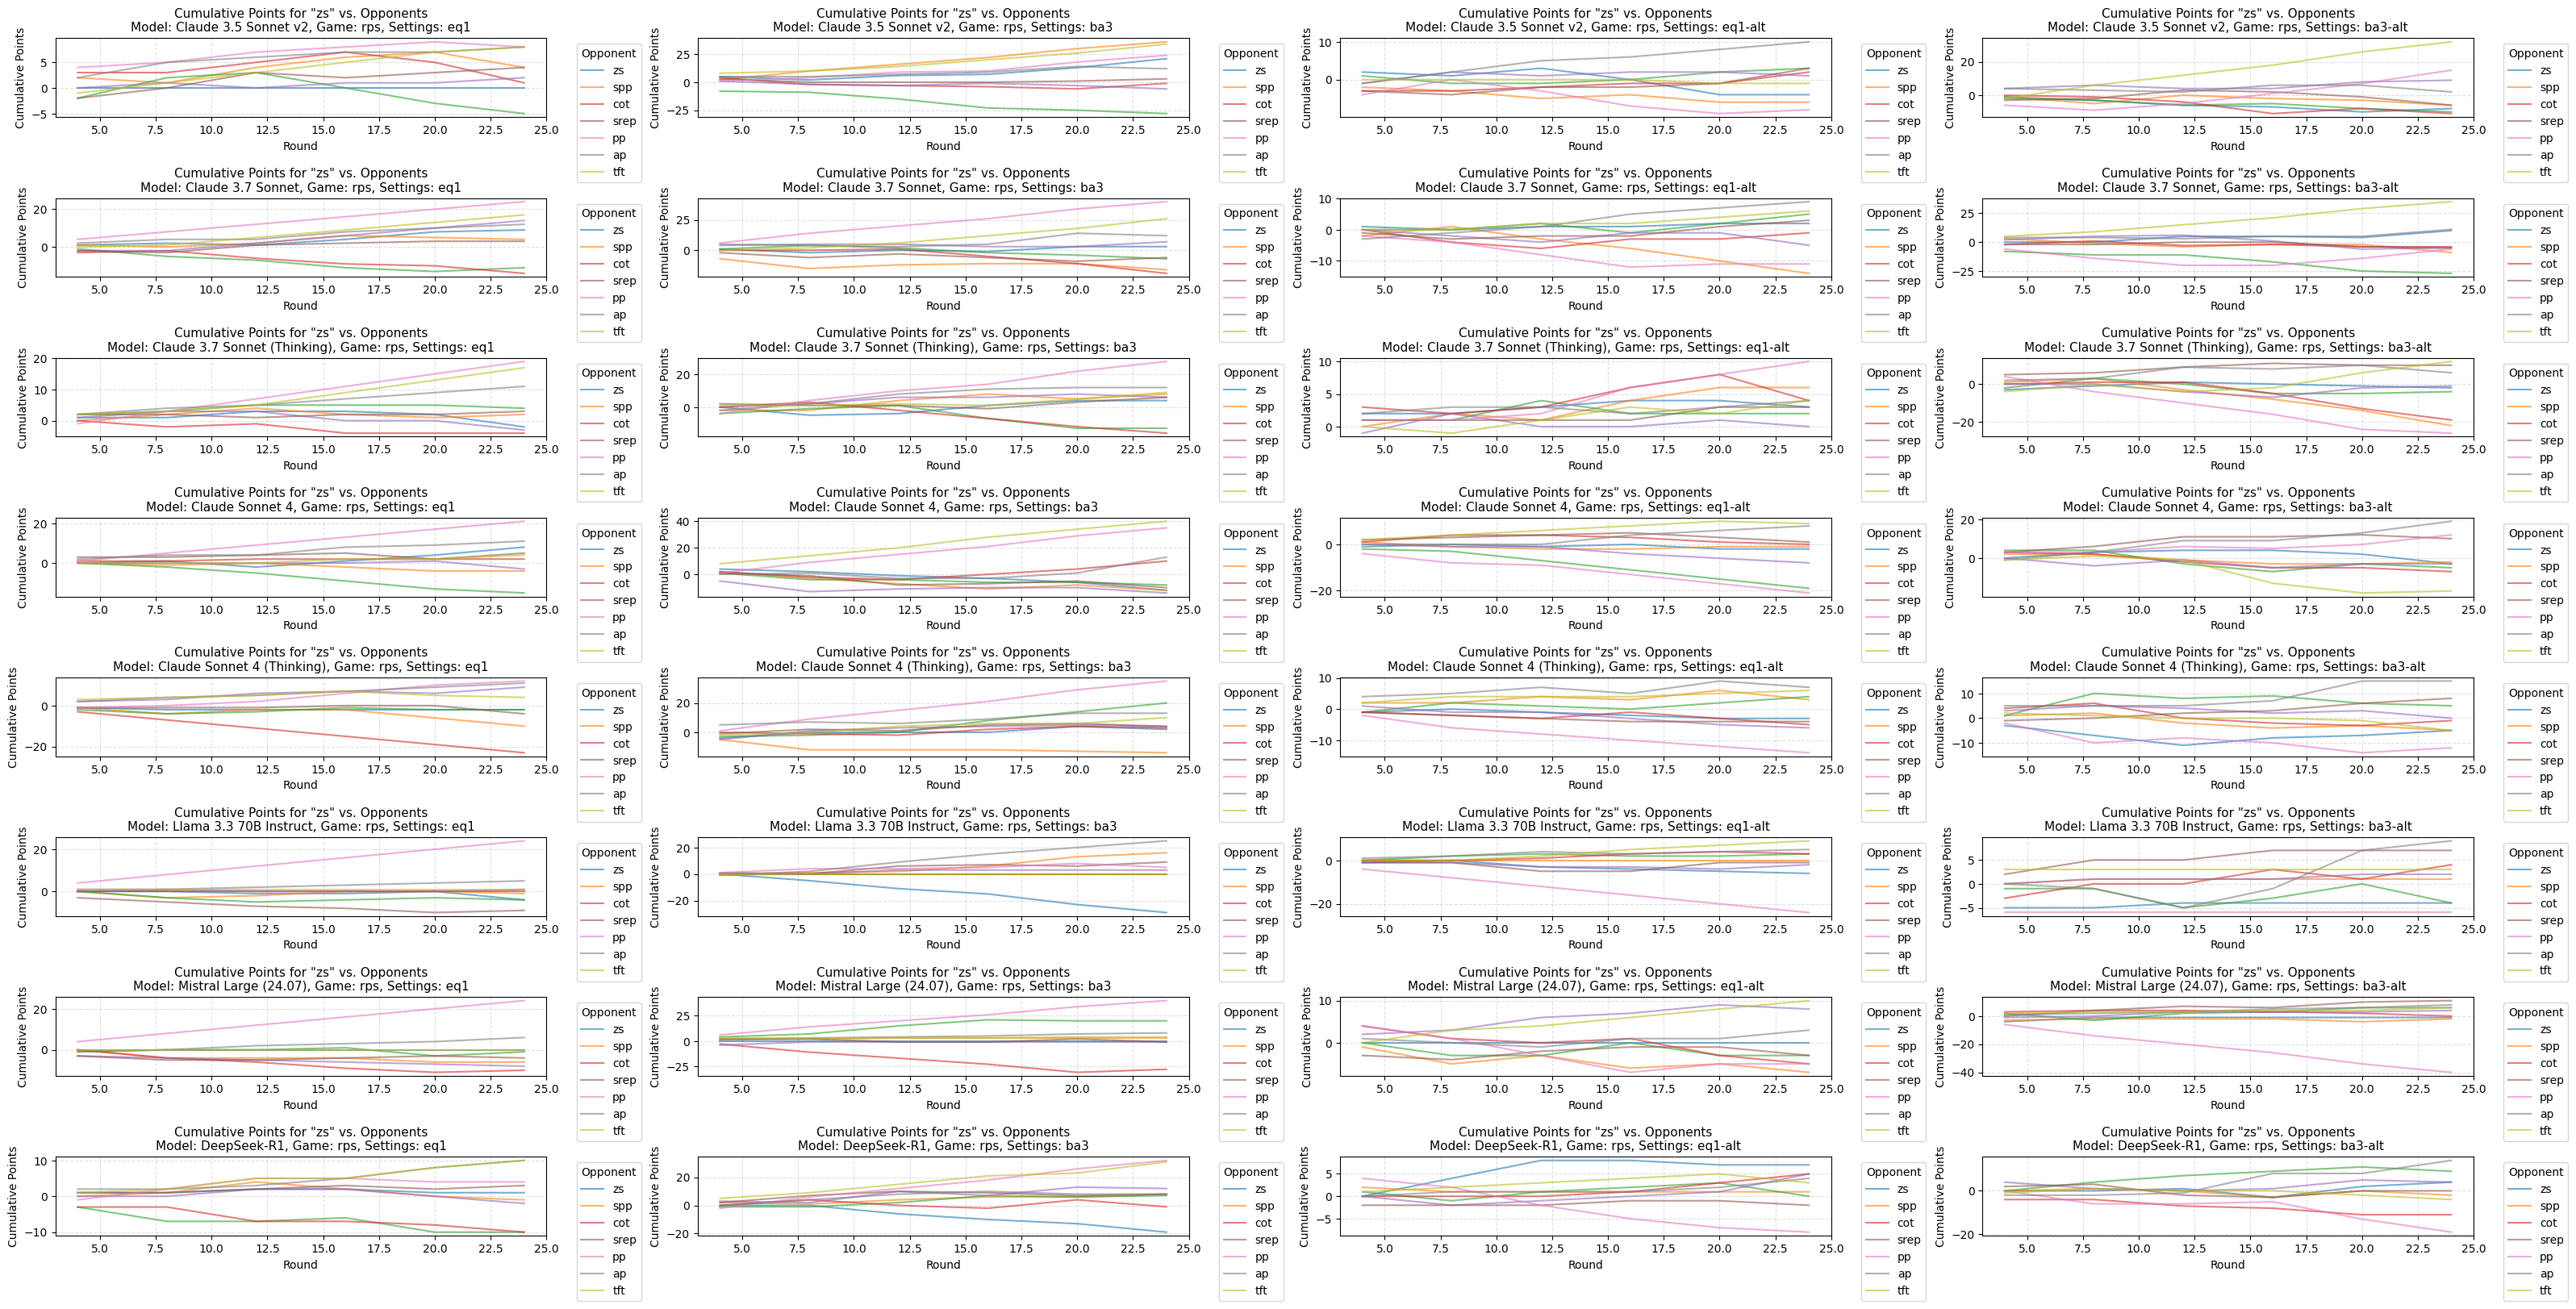

In [51]:
plot_cumulative_points_of_group("default", "../logs/logs_3/data/iteration_1")

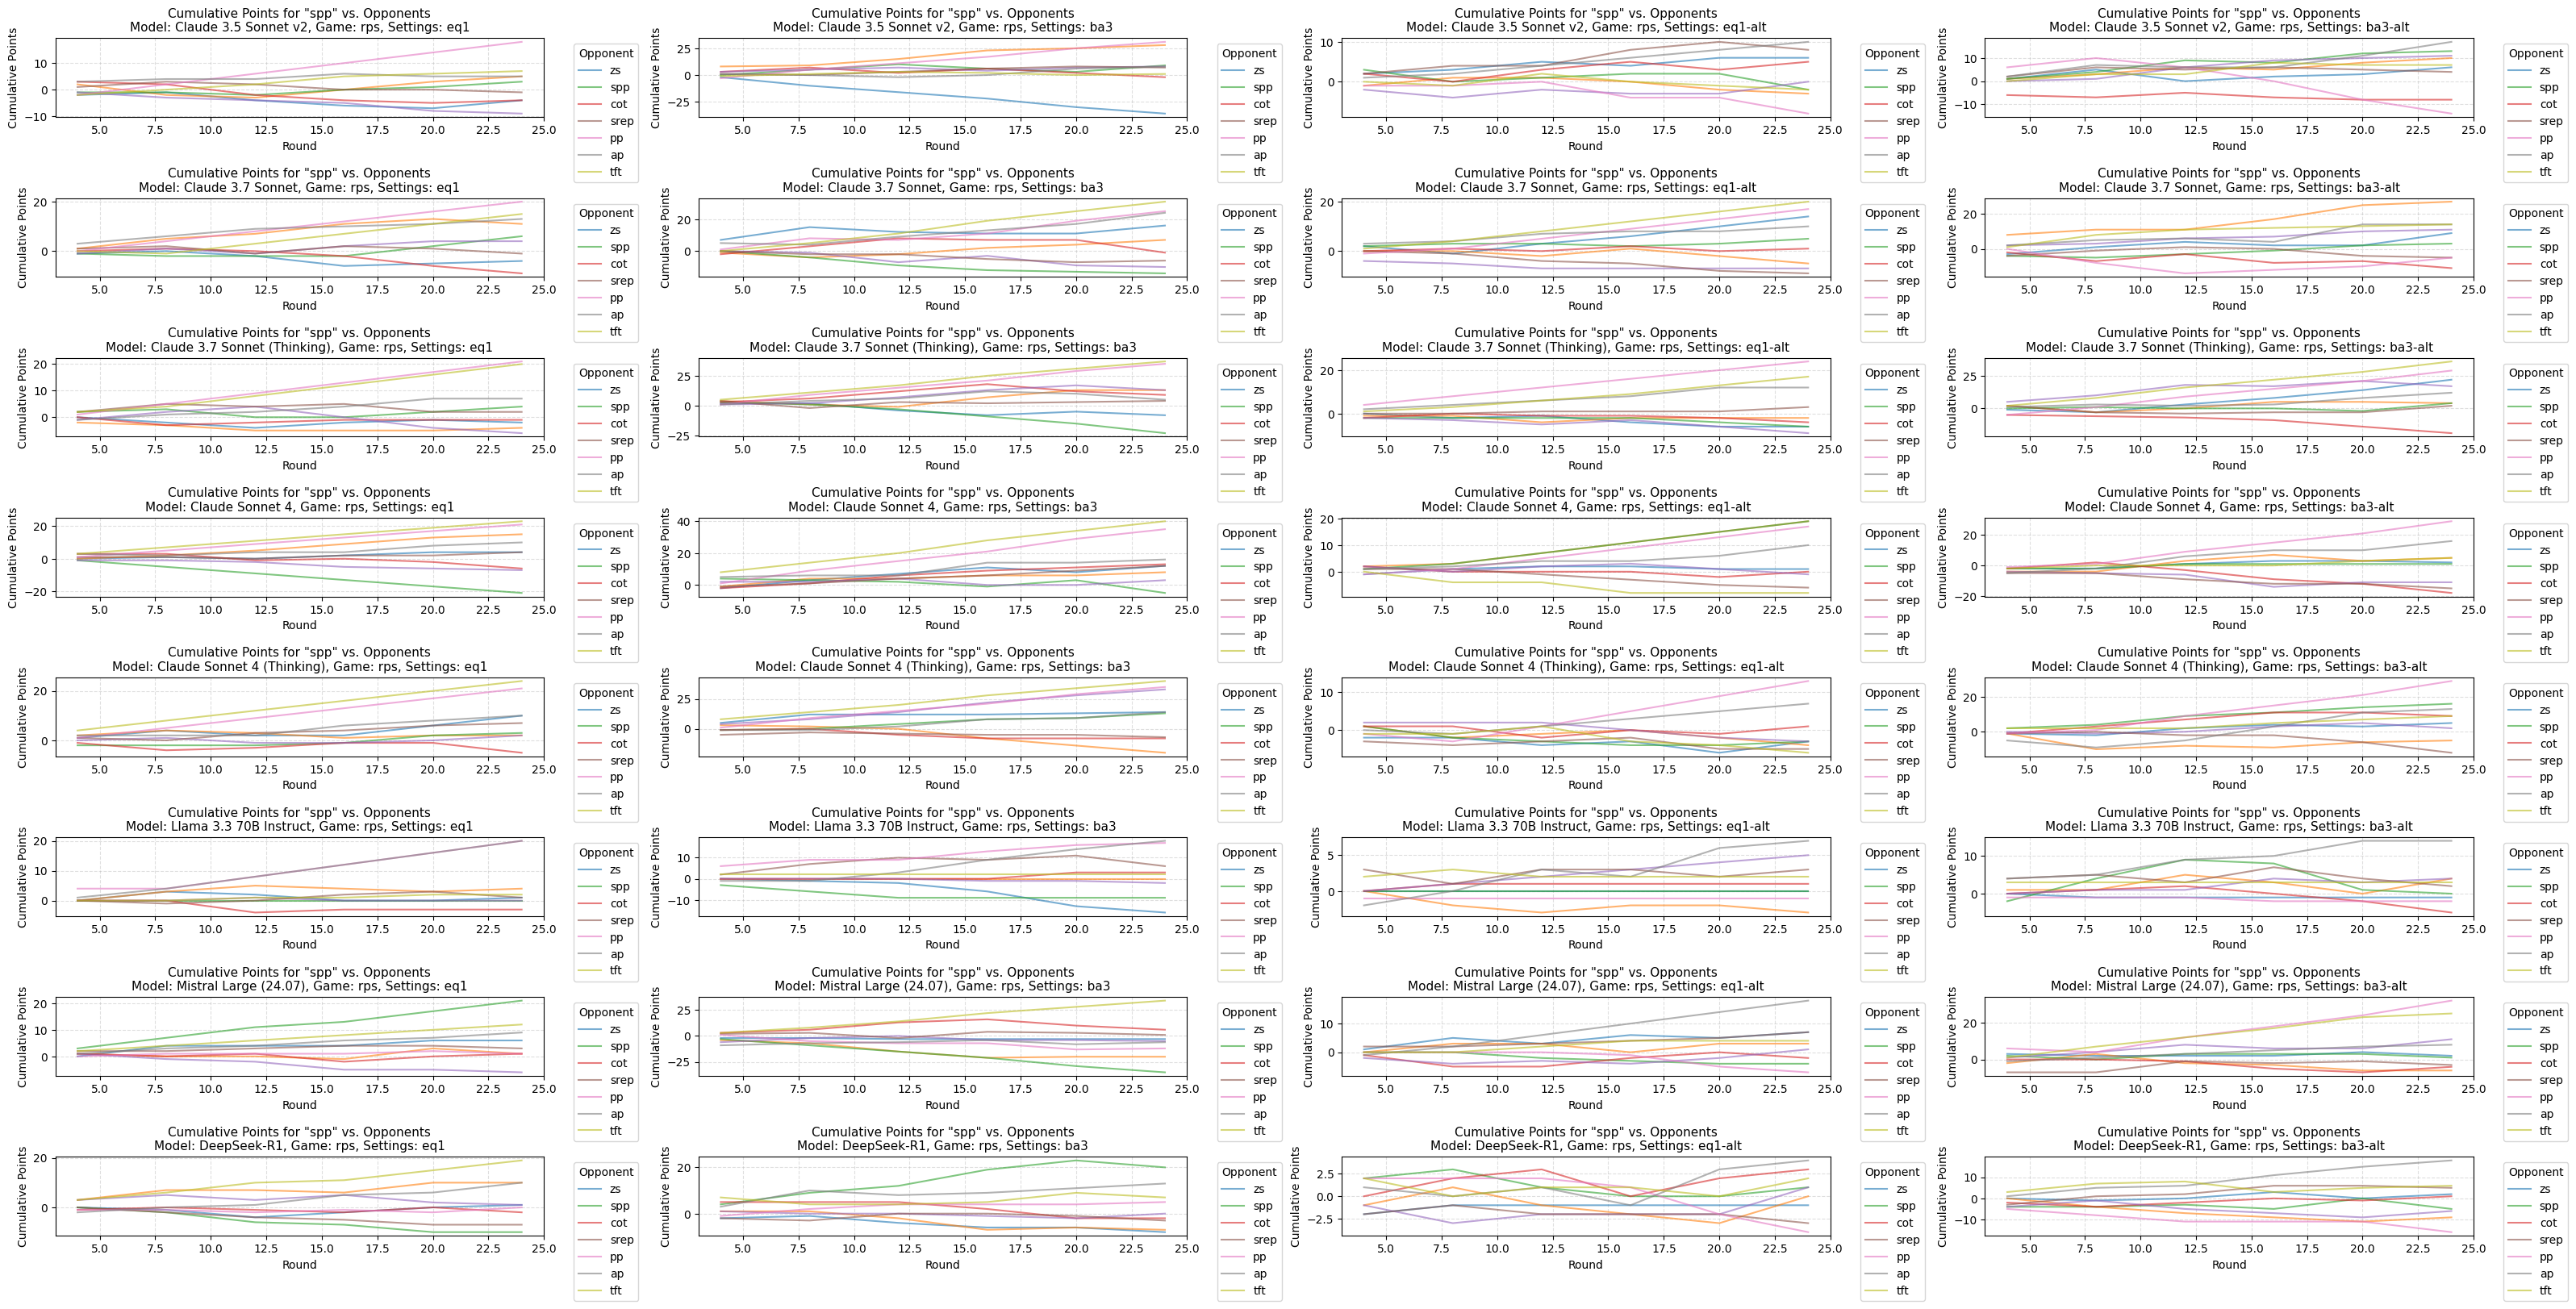

In [52]:
plot_cumulative_points_of_group("spp", "../logs/logs_3/data/iteration_1")

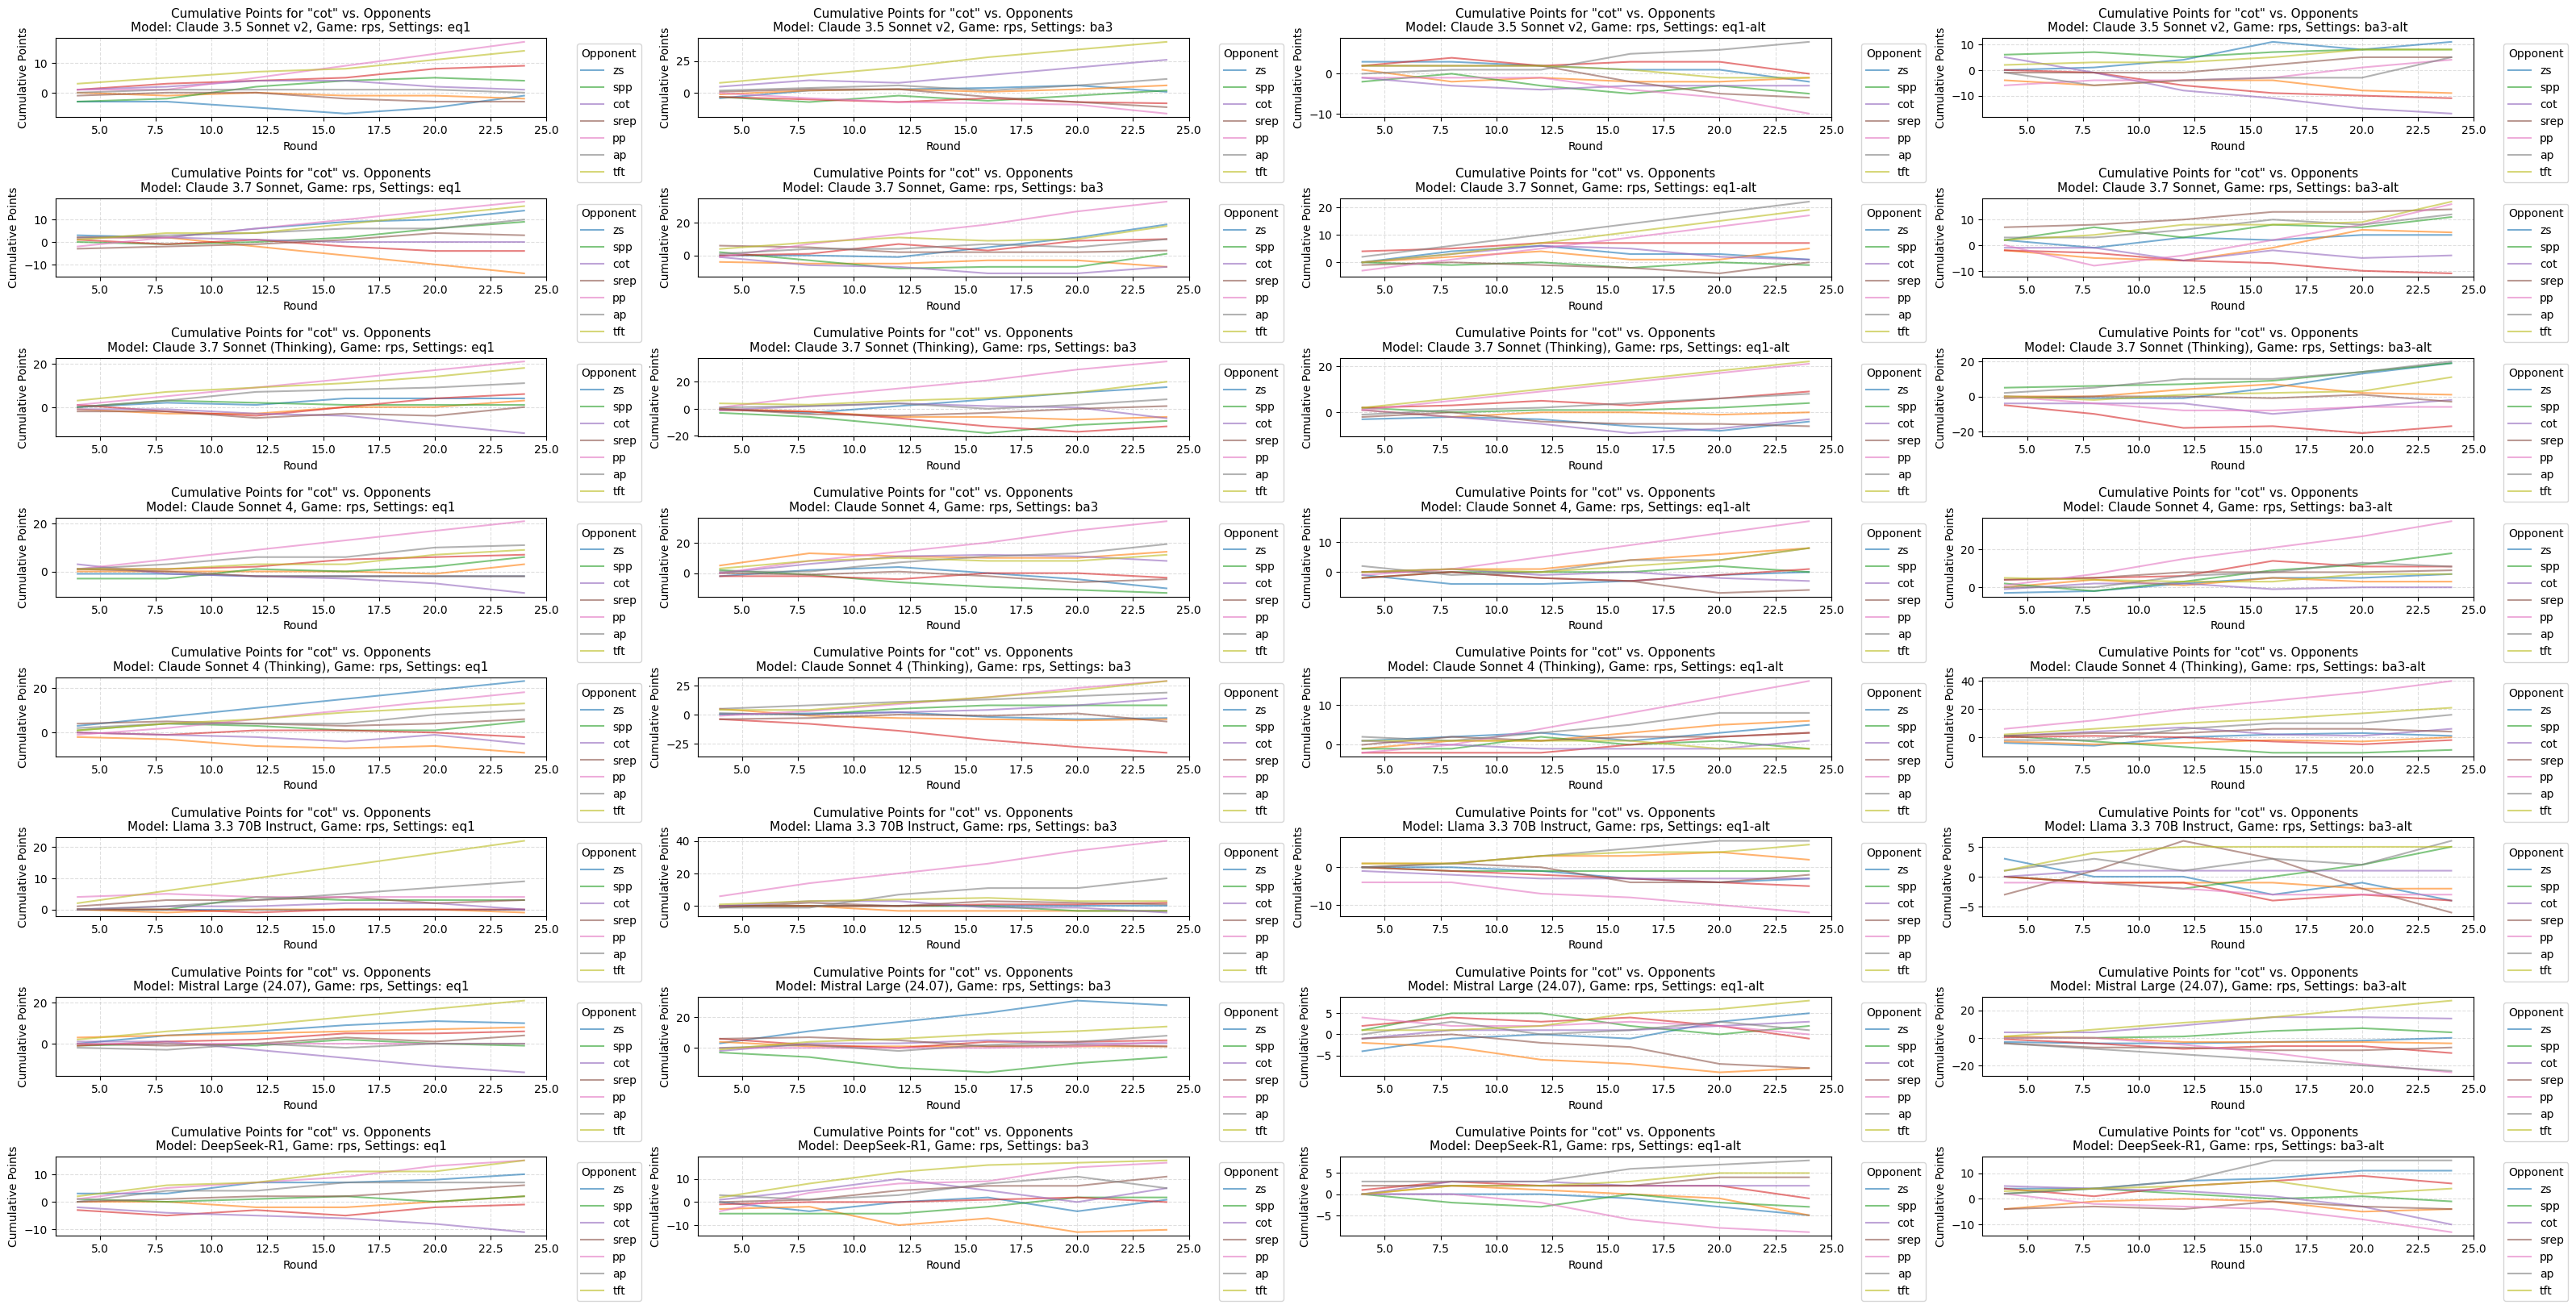

In [53]:
plot_cumulative_points_of_group("cot", "../logs/logs_3/data/iteration_1")

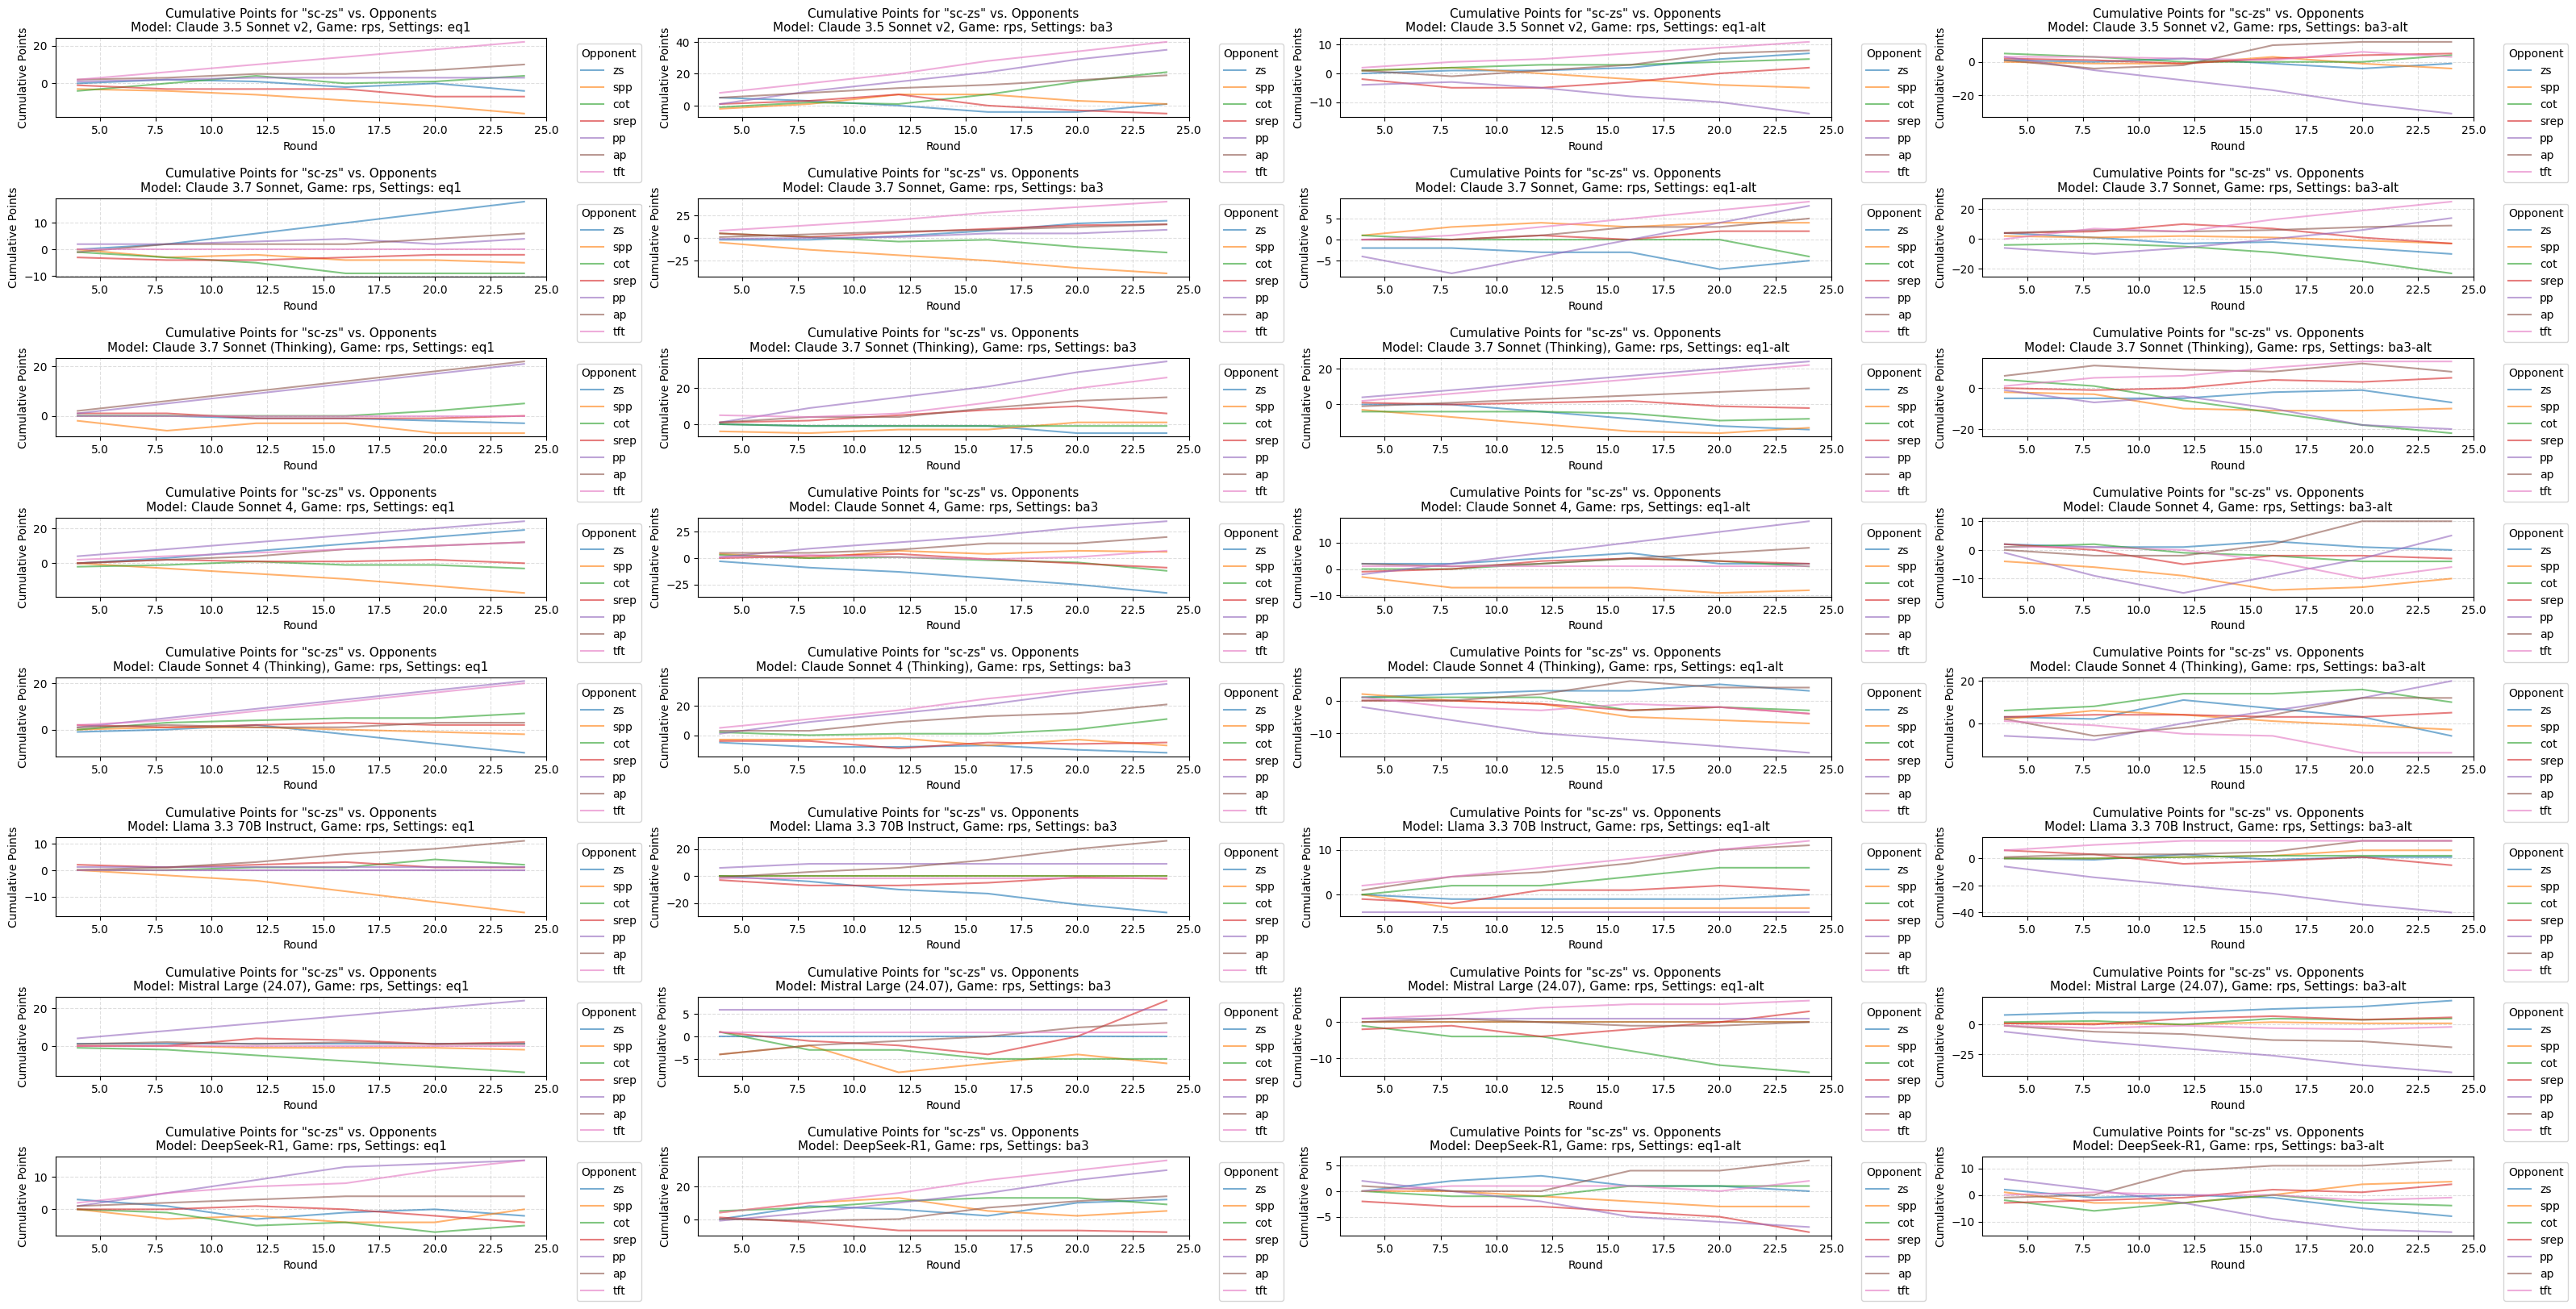

In [54]:
plot_cumulative_points_of_group("default", "../logs/logs_3/data_tot/iteration_1", True)

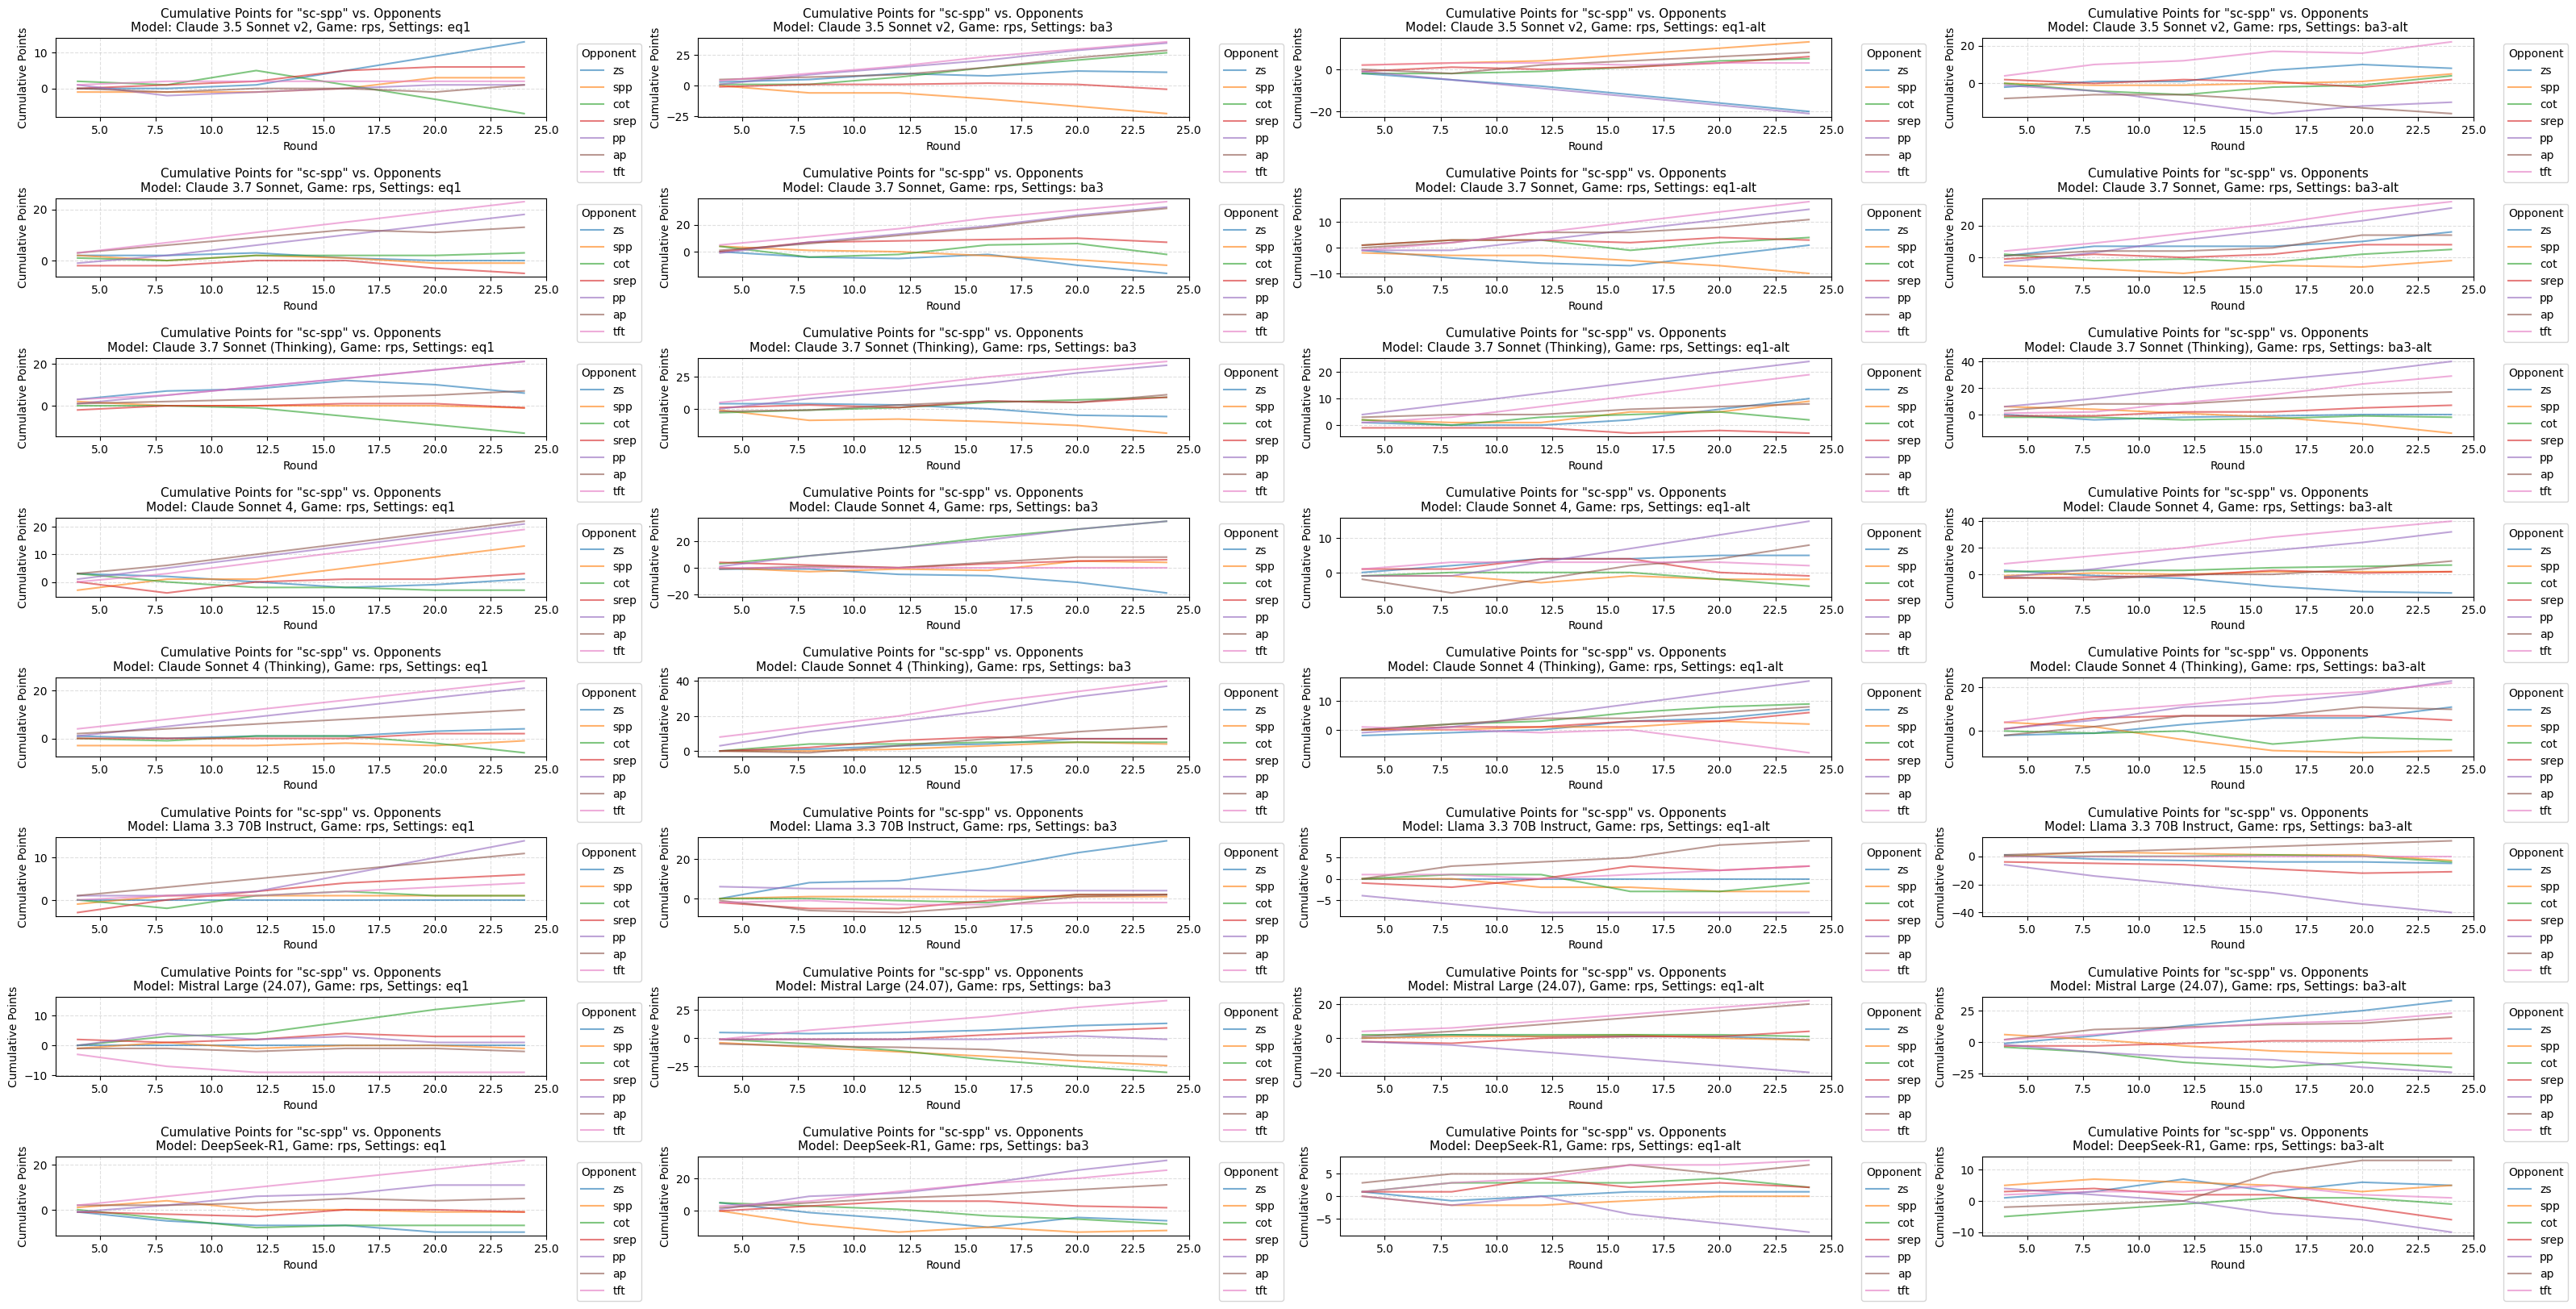

In [55]:
plot_cumulative_points_of_group("spp", "../logs/logs_3/data_tot/iteration_1", True)

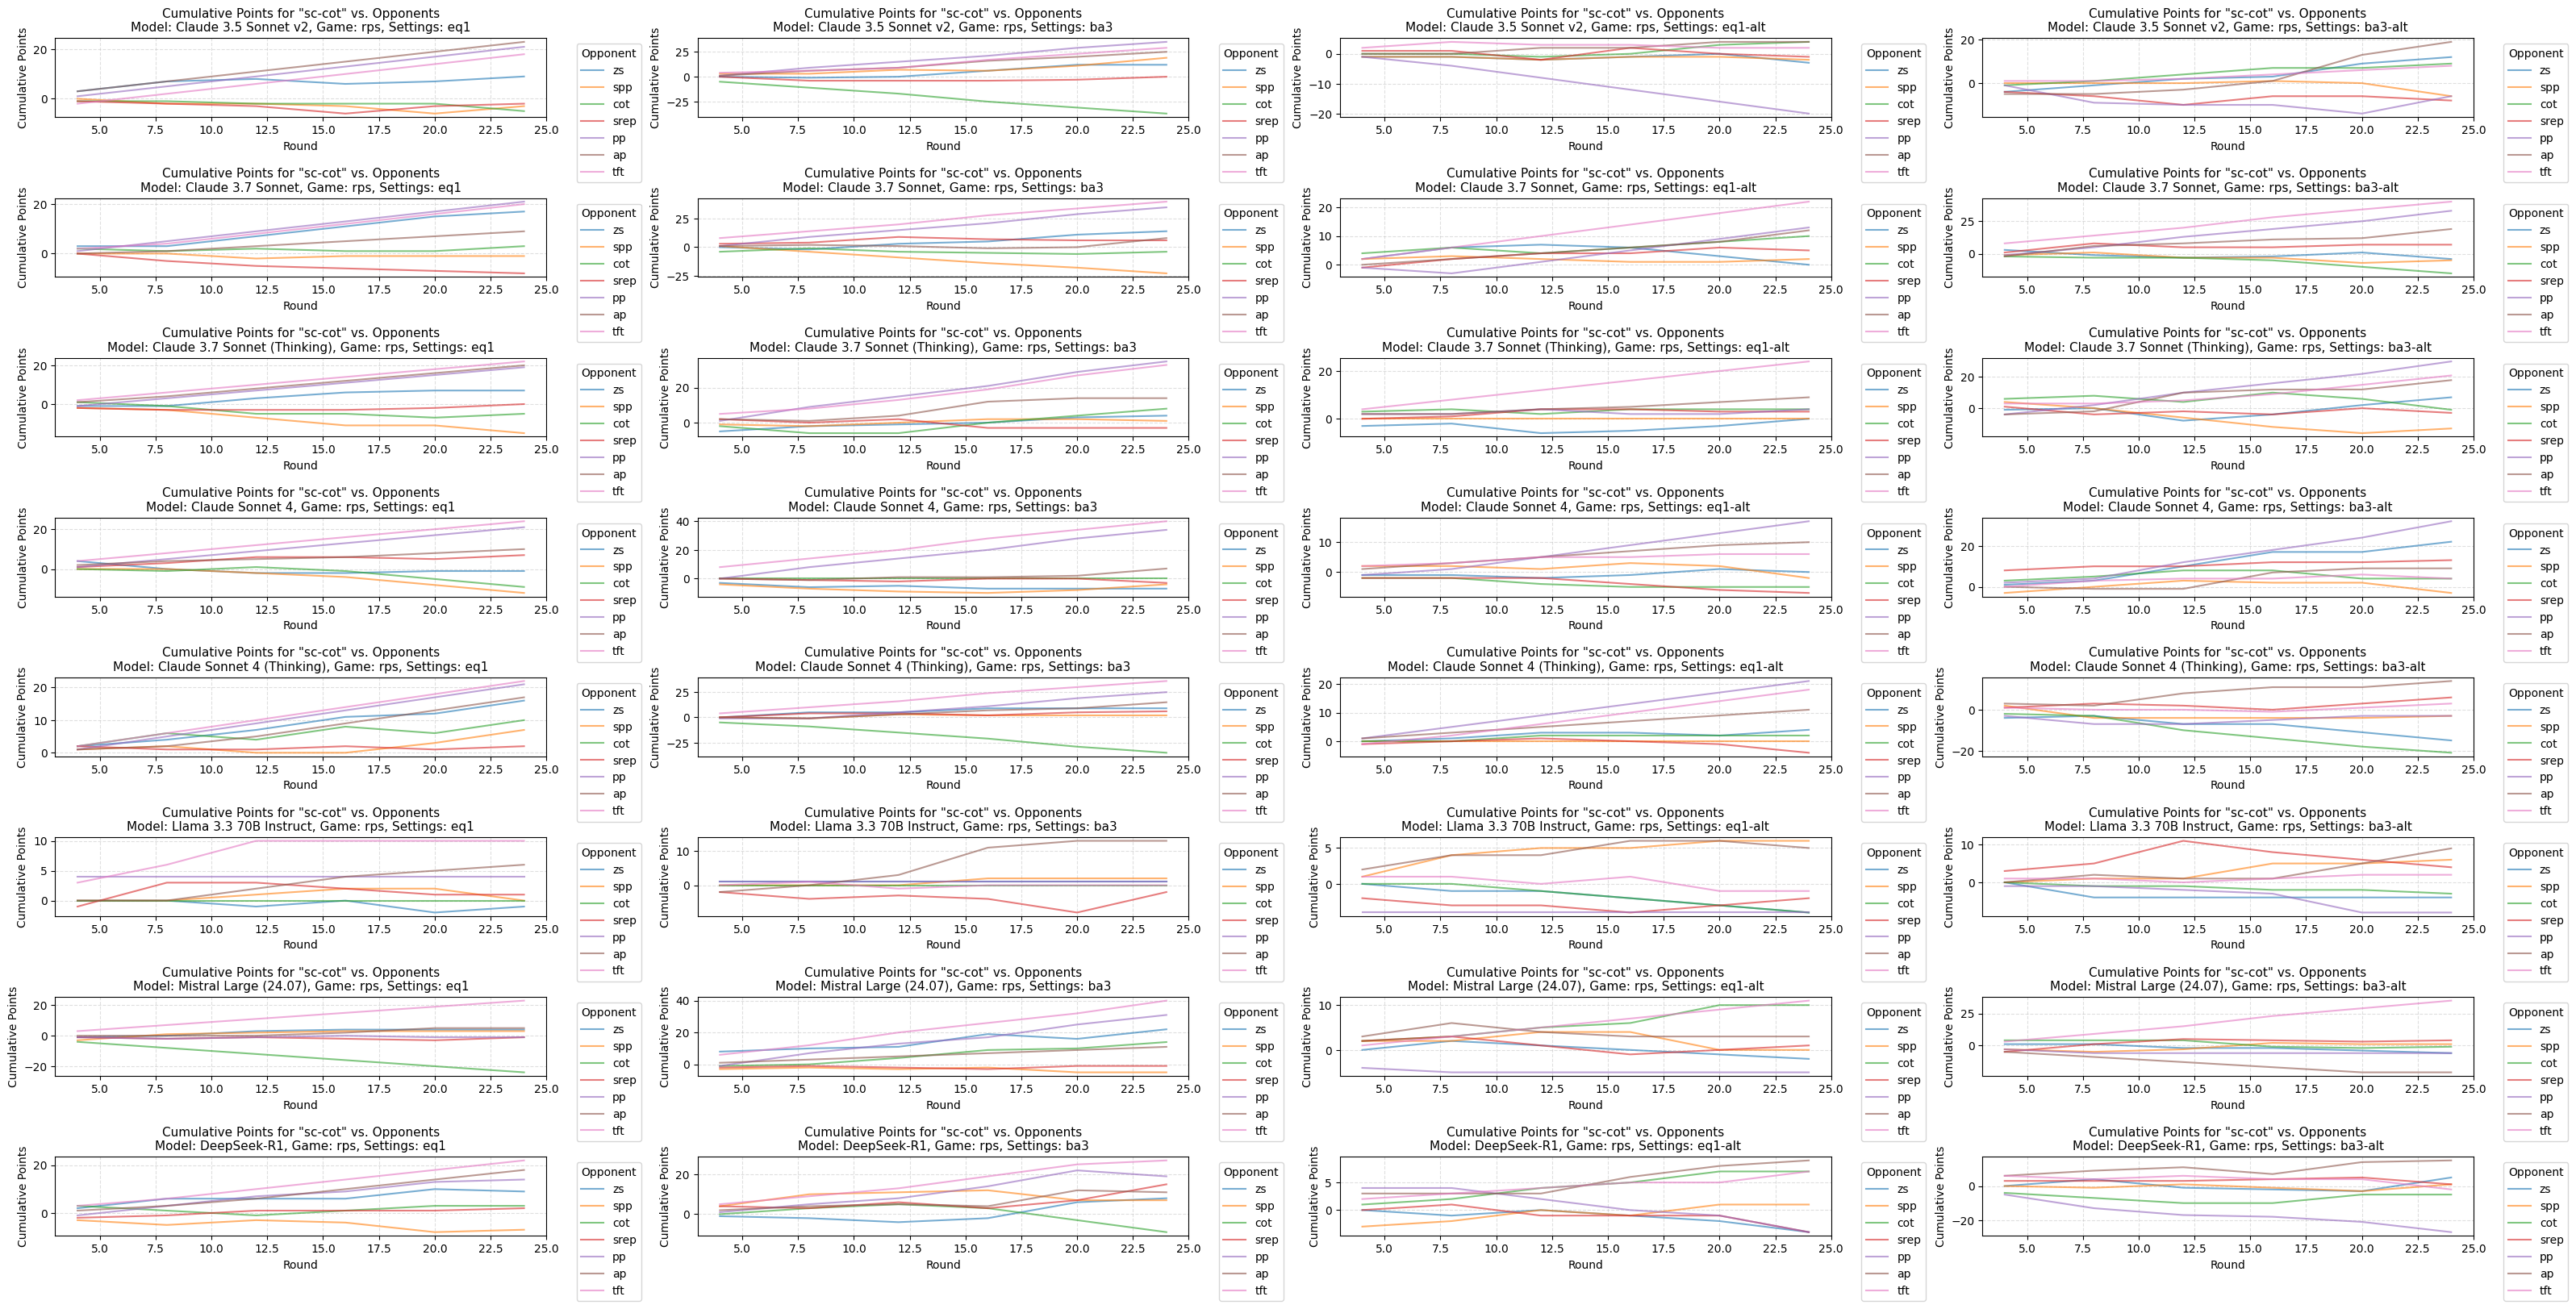

In [56]:
plot_cumulative_points_of_group("cot", "../logs/logs_3/data_tot/iteration_1", True)

In [ ]:
from collections import defaultdict
import os
import json
import numpy as np
import matplotlib.pyplot as plt

def plot_total_points_heatmap(
    log_dir: str,
    model_names: list[str],
    prompt_types: list[str],
    game_type: str,
    game_settings_type: str,
    iteration_cnt: int,
    ax: plt.Axes,
    tot: bool = False,
):
    y_replacements = {
        "default": "zs",
    } if not tot else {
        "default": "sc-zs",
        "spp": "sc-spp",
        "cot": "sc-cot",
    }
    x_replacements = {
        "default": "zs",
    } 

    # {(model, prompt) -> {opponent_type -> total_points}}
    heatmap_data = defaultdict(lambda: defaultdict(float))
    opponent_set = set()

    for model in model_names:
        for prompt in prompt_types:
            for itr in range(iteration_cnt):
                directory = os.path.join(log_dir, f"iteration_{itr}", model, game_type, game_settings_type)

                if not os.path.isdir(directory):
                    continue

                for game_dir in sorted(
                    os.listdir(directory),
                    #key=lambda x: int(x.split('_')[-1]),
                    ):
                    info_path = os.path.join(directory, game_dir, 'game.json')
                    if not os.path.isfile(info_path):
                        continue

                    with open(info_path) as f:
                        info = json.load(f)

                    # Identify which player is the model (model_path)
                    player_types = [info.get(f"player_{i}_player_type") for i in range(2)]
                    if prompt not in player_types:
                        continue  # Skip if this game doesn't include the current model+prompt

                    model_idx = player_types.index(prompt)

                    if model_idx != 0 and tot:
                        continue

                    opponent_type = player_types[1 - model_idx]
                    opponent_set.add(opponent_type)

                    total_points = info.get(f"player_{model_idx}_total_points")
                    if total_points is None:
                        raise ValueError(f"Missing total_points for {info_path}")

                    heatmap_data[(model, prompt)][opponent_type] += total_points

    # If no data collected, raise error
    if not heatmap_data:
        raise ValueError("No data collected — check log paths and model+prompt naming conventions.")
    
    # Normalize data by iteration count
    for key in heatmap_data:
        for opponent in heatmap_data[key]:
            heatmap_data[key][opponent] /= iteration_cnt

    opponent_types_aux = ["default", "spp", "cot", "srep", "pp", "ap", "tft"]
    sorted_opponents = [opp for opp in opponent_types_aux if opp in opponent_set]
    model_prompt_keys = [(model, prompt) for model in model_names for prompt in prompt_types]

    # Build matrix
    matrix = np.zeros((len(model_prompt_keys), len(sorted_opponents)))
    for i, key in enumerate(model_prompt_keys):
        for j, opponent in enumerate(sorted_opponents):
            matrix[i, j] = heatmap_data[key].get(opponent, -1000)

    # Plot heatmap
    im = ax.imshow(matrix, cmap='viridis', aspect='auto')

    # Ticks and labels
    x_labels = sorted_opponents
    for old, new in x_replacements.items():
        x_labels = [label.replace(old, new) for label in x_labels]
    ax.set_xticks(np.arange(len(sorted_opponents)))
    ax.set_xticklabels(x_labels, rotation=45, ha='right')

    row_labels = list()
    for model, prompt in model_prompt_keys:
        for old, new in y_replacements.items():
            prompt = prompt.replace(old, new)
        row_labels.append(f"{model}\n{prompt}")
    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_yticklabels(row_labels)

    # Annotate cells
    for i in range(len(model_prompt_keys)):
        for j in range(len(sorted_opponents)):
            ax.text(j, i, f"{int(matrix[i, j])}", ha='center', va='center',
                    color='white' if matrix[i, j] < np.max(matrix)/2 else 'black')

    ax.set_title(
        f"Total Points Averaged Over {iteration_cnt} Runs\n"
        f"Game: {game_type}, Settings: {game_settings_type}"
    )
    ax.set_xlabel("Opponent Player Type")
    ax.set_ylabel("Model + Prompt Type")

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# flatten ax to 1D for easier indexing
axs = axs.flatten()

for ax, game_settings_type in zip(axs, ["eq1", "ba3", "eq1-alt", "ba3-alt"]):
    plot_total_points_heatmap(
        log_dir="../logs/logs_3/data",
        model_names=[model["name"] for model in models],
        prompt_types=["default", "spp", "cot"],
        game_type="rps",
        game_settings_type=game_settings_type,
        iteration_cnt=5,
        ax=ax,
        tot=False,
    )

plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# flatten ax to 1D for easier indexing
axs = axs.flatten()

for ax, game_settings_type in zip(axs, ["eq1", "ba3", "eq1-alt", "ba3-alt"]):
    plot_total_points_heatmap(
        log_dir="../logs/logs_3/data_tot",
        model_names=[model["name"] for model in models],
        prompt_types=["default", "spp", "cot"],
        game_type="rps",
        game_settings_type=game_settings_type,
        iteration_cnt=2,
        ax=ax,
        tot=True,
    )

plt.tight_layout()
plt.show()


In [ ]:
# currently not used
def plot_total_tokens_heatmap(
    log_dir: str,
    model_names: list[str],
    prompt_types: list[str],
    game_type: str,
    game_settings_type: str,
    iteration_cnt: int,
    ax: plt.Axes,
    tot: bool = False,
):
    from collections import defaultdict
    import os
    import json
    import numpy as np
    import matplotlib.pyplot as plt

    # {(model, prompt) -> {opponent_type -> total_tokens}}
    heatmap_data = defaultdict(lambda: defaultdict(float))
    opponent_set = set()

    for model in model_names:
        for prompt in prompt_types:
            for itr in range(iteration_cnt):
                directory = os.path.join(log_dir, f"iteration_{itr}", model, game_type, game_settings_type)

                if not os.path.isdir(directory):
                    continue

                for game_dir in sorted(
                    os.listdir(directory),
                    #key=lambda x: int(x.split('_')[-1]),
                    ):
                    info_path = os.path.join(directory, game_dir, 'game.json')
                    if not os.path.isfile(info_path):
                        continue

                    with open(info_path) as f:
                        info = json.load(f)

                    # Identify which player is the model (model_path)
                    player_types = [info.get(f"player_{i}_player_type") for i in range(2)]
                    if prompt not in player_types:
                        continue  # Skip if this game doesn't include the current model+prompt

                    model_idx = player_types.index(prompt)

                    if model_idx != 0 and tot:
                        continue

                    opponent_type = player_types[1 - model_idx]
                    opponent_set.add(opponent_type)

                    tokens = info.get(f"player_{model_idx}_tokens")
                    if tokens is None:
                        raise ValueError(f"Missing tokens for {info_path}")

                    heatmap_data[(model, prompt)][opponent_type] += max(tokens)

    # If no data collected, raise error
    if not heatmap_data:
        raise ValueError("No data collected — check log paths and model+prompt naming conventions.")
    
    # Normalize data by iteration count
    for key in heatmap_data:
        for opponent in heatmap_data[key]:
            heatmap_data[key][opponent] /= iteration_cnt

    opponent_types_aux = ["default", "spp", "cot", "srep", "pp", "ap", "tft"]
    sorted_opponents = [opp for opp in opponent_types_aux if opp in opponent_set]
    model_prompt_keys = [(model, prompt) for model in model_names for prompt in prompt_types]

    # Build matrix
    matrix = np.zeros((len(model_prompt_keys), len(sorted_opponents)))
    for i, key in enumerate(model_prompt_keys):
        for j, opponent in enumerate(sorted_opponents):
            matrix[i, j] = heatmap_data[key].get(opponent, -100_000)

    # Plot heatmap
    im = ax.imshow(matrix, cmap='viridis', aspect='auto')

    # Ticks and labels
    ax.set_xticks(np.arange(len(sorted_opponents)))
    ax.set_xticklabels(sorted_opponents, rotation=45, ha='right')

    row_labels = [f"{model}\n{prompt}" for model, prompt in model_prompt_keys]
    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_yticklabels(row_labels)

    # Annotate cells
    for i in range(len(model_prompt_keys)):
        for j in range(len(sorted_opponents)):
            ax.text(j, i, f"{int(matrix[i, j])}", ha='center', va='center',
                    color='white' if matrix[i, j] < np.max(matrix)/2 else 'black')

    ax.set_title(
        f"Total Tokens Averaged Over {iteration_cnt} Runs\n"
        f"Game: {game_type}, Settings: {game_settings_type}"
    )
    ax.set_xlabel("Opponent Player Type")
    ax.set_ylabel("Model + Prompt Type")

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


In [ ]:
from collections import defaultdict
import os
import json
import numpy as np
import matplotlib.pyplot as plt

def plot_total_tokens(
    log_dir: str,
    model_names: list[str],
    prompt_types: list[str],
    game_type: str,
    game_settings_type: str,
    iteration_cnt: int,
    ax: plt.Axes,
    tot: bool = False,
):
    y_replacements = {
        "default": "zs",
    } if not tot else {
        "default": "sc-zs",
        "spp": "sc-spp",
        "cot": "sc-cot",
    }
    x_replacements = {
        "default": "zs",
    }

    # {(model, prompt) -> {opponent_type -> total_tokens}}
    token_data = defaultdict(lambda: defaultdict(float))
    opponent_set = set()

    for model in model_names:
        for prompt in prompt_types:
            for itr in range(iteration_cnt):
                directory = os.path.join(log_dir, f"iteration_{itr}", model, game_type, game_settings_type)

                if not os.path.isdir(directory):
                    continue

                for game_dir in sorted(
                    os.listdir(directory),
                    #key=lambda x: int(x.split('_')[-1]),
                    ):
                    info_path = os.path.join(directory, game_dir, 'game.json')
                    if not os.path.isfile(info_path):
                        continue

                    with open(info_path) as f:
                        info = json.load(f)

                    player_types = [info.get(f"player_{i}_player_type") for i in range(2)]
                    if prompt not in player_types:
                        continue

                    model_idx = player_types.index(prompt)
                    if model_idx != 0 and tot:
                        continue

                    opponent_type = player_types[1 - model_idx]
                    opponent_set.add(opponent_type)

                    tokens = info.get(f"player_{model_idx}_tokens")
                    if tokens is None:
                        raise ValueError(f"Missing tokens for {info_path}")

                    token_data[(model, prompt)][opponent_type] += max(tokens)

    if not token_data:
        raise ValueError("No data collected — check paths and naming conventions.")

    for key in token_data:
        for opp in token_data[key]:
            token_data[key][opp] /= iteration_cnt

    opponent_types_aux = ["default", "spp", "cot", "srep", "pp", "ap", "tft"]
    sorted_opponents = [opp for opp in opponent_types_aux if opp in opponent_set]
    model_prompt_keys = [(model, prompt) for model in model_names for prompt in prompt_types]

    # add opponent type "avg"
    for key in token_data:
        aux = 0
        for opp in sorted_opponents:
            if opp in token_data[key]:
                aux += token_data[key][opp]
        token_data[key]["avg"] = aux / len(sorted_opponents)

    sorted_opponents.append("avg")

    x = np.arange(len(sorted_opponents))

    for (model, prompt) in model_prompt_keys:
        y_values = [token_data[(model, prompt)].get(opp, np.nan) for opp in sorted_opponents]
        for old, new in y_replacements.items():
            prompt = prompt.replace(old, new)
        label = f"{model} + {prompt}"
        ax.plot(x, y_values, marker='o', label=label)

    x_labels = sorted_opponents
    for old, new in x_replacements.items():
        x_labels = [label.replace(old, new) for label in x_labels]
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    ax.set_ylabel("Avg Total Tokens")
    ax.set_xlabel("Opponent Player Type")
    ax.set_title(
        f"Total Tokens Averaged Over {iteration_cnt} Runs\n"
        f"Game: {game_type}, Settings: {game_settings_type}"
    )
    ax.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# flatten ax to 1D for easier indexing
axs = axs.flatten()

for ax, game_settings_type in zip(axs, ["eq1", "ba3", "eq1-alt", "ba3-alt"]):
    plot_total_tokens(
        log_dir="../logs/logs_3/data",
        model_names=[model["name"] for model in models],
        prompt_types=["default", "spp", "cot"],
        game_type="rps",
        game_settings_type=game_settings_type,
        iteration_cnt=5,
        ax=ax,
        tot=False,
    )

plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# flatten ax to 1D for easier indexing
axs = axs.flatten()

for ax, game_settings_type in zip(axs, ["eq1", "ba3", "eq1-alt", "ba3-alt"]):
    plot_total_tokens(
        log_dir="../logs/logs_3/data_tot",
        model_names=[model["name"] for model in models],
        prompt_types=["default", "spp", "cot"],
        game_type="rps",
        game_settings_type=game_settings_type,
        iteration_cnt=2,
        ax=ax,
        tot=True,
    )

plt.tight_layout()
plt.show()


In [ ]:
from collections import defaultdict
import os
import json
import numpy as np
import matplotlib.pyplot as plt

def plot_efficiency(
    log_dir: str,
    model_names: list[str],
    prompt_types: list[str],
    game_type: str,
    game_settings_type: str,
    iteration_cnt: int,
    ax: plt.Axes,
    tot: bool = False,
):
    y_replacements = {
        "default": "zs",
    } if not tot else {
        "default": "sc-zs",
        "spp": "sc-spp",
        "cot": "sc-cot",
    }
    x_replacements = {
        "default": "zs",
    }

    # {(model, prompt) -> {opponent_type -> efficiency}}
    effiency_data = defaultdict(lambda: defaultdict(float))
    opponent_set = set()

    for model in model_names:
        for prompt in prompt_types:
            for itr in range(iteration_cnt):
                directory = os.path.join(log_dir, f"iteration_{itr}", model, game_type, game_settings_type)

                if not os.path.isdir(directory):
                    continue

                for game_dir in sorted(
                    os.listdir(directory),
                    #key=lambda x: int(x.split('_')[-1]),
                    ):
                    info_path = os.path.join(directory, game_dir, 'game.json')
                    if not os.path.isfile(info_path):
                        continue

                    with open(info_path) as f:
                        info = json.load(f)

                    player_types = [info.get(f"player_{i}_player_type") for i in range(2)]
                    if prompt not in player_types:
                        continue

                    model_idx = player_types.index(prompt)
                    if model_idx != 0 and tot:
                        continue

                    opponent_type = player_types[1 - model_idx]
                    opponent_set.add(opponent_type)

                    tokens = info.get(f"player_{model_idx}_tokens")
                    if tokens is None:
                        raise ValueError(f"Missing tokens for {info_path}")
                    
                    total_points = info.get(f"player_{model_idx}_total_points")
                    if total_points is None:
                        raise ValueError(f"Missing total_points for {info_path}")

                    effiency_data[(model, prompt)][opponent_type] += total_points / max(tokens)

    if not effiency_data:
        raise ValueError("No data collected — check paths and naming conventions.")

    for key in effiency_data:
        for opp in effiency_data[key]:
            effiency_data[key][opp] /= iteration_cnt

    opponent_types_aux = ["default", "spp", "cot", "srep", "pp", "ap", "tft"]
    sorted_opponents = [opp for opp in opponent_types_aux if opp in opponent_set]
    model_prompt_keys = [(model, prompt) for model in model_names for prompt in prompt_types]

    # add opponent type "avg"
    for key in effiency_data:
        aux = 0
        for opp in sorted_opponents:
            if opp in effiency_data[key]:
                aux += effiency_data[key][opp]
        effiency_data[key]["avg"] = aux / len(sorted_opponents)

    sorted_opponents.append("avg")

    x = np.arange(len(sorted_opponents))

    for (model, prompt) in model_prompt_keys:
        y_values = [effiency_data[(model, prompt)].get(opp, np.nan) for opp in sorted_opponents]
        for old, new in y_replacements.items():
            prompt = prompt.replace(old, new)
        label = f"{model} + {prompt}"
        ax.plot(x, y_values, marker='o', label=label)

    x_labels = sorted_opponents
    for old, new in x_replacements.items():
        x_labels = [label.replace(old, new) for label in x_labels]
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    ax.set_ylabel("Avg Efficiency")
    ax.set_xlabel("Opponent Player Type")
    ax.set_title(
        f"Effiency (Points per Token) Averaged Over {iteration_cnt} Runs\n"
        f"Game: {game_type}, Settings: {game_settings_type}"
    )
    ax.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)


In [ ]:
from collections import defaultdict
import os
import json
import numpy as np
import matplotlib.pyplot as plt

def plot_efficiency(
    log_dir: str,
    model_names: list[str],
    prompt_types: list[str],
    game_type: str,
    game_settings_type: str,
    iteration_cnt: int,
    ax: plt.Axes,
    tot: bool = False,
):
    y_replacements = {
        "default": "zs",
    } if not tot else {
        "default": "sc-zs",
        "spp": "sc-spp",
        "cot": "sc-cot",
    }
    x_replacements = {
        "default": "zs",
    }

    efficiency_data = defaultdict(lambda: defaultdict(float))
    opponent_set = set()

    for model in model_names:
        for prompt in prompt_types:
            for itr in range(iteration_cnt):
                directory = os.path.join(log_dir, f"iteration_{itr}", model, game_type, game_settings_type)

                if not os.path.isdir(directory):
                    continue

                for game_dir in sorted(
                    os.listdir(directory),
                    #key=lambda x: int(x.split('_')[-1]),
                    ):
                    info_path = os.path.join(directory, game_dir, 'game.json')
                    if not os.path.isfile(info_path):
                        continue

                    with open(info_path) as f:
                        info = json.load(f)

                    player_types = [info.get(f"player_{i}_player_type") for i in range(2)]
                    if prompt not in player_types:
                        continue

                    model_idx = player_types.index(prompt)
                    if model_idx != 0 and tot:
                        continue

                    opponent_type = player_types[1 - model_idx]
                    opponent_set.add(opponent_type)

                    tokens = info.get(f"player_{model_idx}_tokens")
                    total_points = info.get(f"player_{model_idx}_total_points")

                    if tokens is None or total_points is None:
                        print(f"Model {model}, Prompt {prompt}, Iteration {itr}, Game directory {game_dir} - Missing data in {info_path}")
                        raise ValueError(f"Missing tokens or total_points for {info_path}")


                    efficiency_data[(model, prompt)][opponent_type] += total_points / max(tokens) * 1000

    if not efficiency_data:
        raise ValueError("No data collected — check paths and naming conventions.")

    for key in efficiency_data:
        for opp in efficiency_data[key]:
            efficiency_data[key][opp] /= iteration_cnt

    opponent_types_aux = ["default", "spp", "cot", "srep", "pp", "ap", "tft"]
    sorted_opponents = [opp for opp in opponent_types_aux if opp in opponent_set]
    model_prompt_keys = [(model, prompt) for model in model_names for prompt in prompt_types]

    # Compute "avg"
    for key in efficiency_data:
        total = sum(efficiency_data[key][opp] for opp in sorted_opponents if opp in efficiency_data[key])
        efficiency_data[key]["avg"] = total / len(sorted_opponents)

    sorted_opponents.append("avg")

    n_groups = len(sorted_opponents)
    n_models = len(model_prompt_keys)
    bar_width = 0.8 / n_models
    x = np.arange(n_groups)

    for idx, (model, prompt) in enumerate(model_prompt_keys):
        offsets = x + (idx - n_models / 2) * bar_width + bar_width / 2
        y_values = [efficiency_data[(model, prompt)].get(opp, 0) for opp in sorted_opponents]
        for old, new in y_replacements.items():
            prompt = prompt.replace(old, new)
        label = f"{model} + {prompt}"
        ax.bar(offsets, y_values, bar_width, label=label)

    x_labels = sorted_opponents
    for old, new in x_replacements.items():
        x_labels = [label.replace(old, new) for label in x_labels]
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    ax.set_ylabel("Avg Efficiency (Points per Token)")
    ax.set_xlabel("Opponent Player Type")
    ax.set_title(
        f"Efficiency (Points per Token) Averaged Over {iteration_cnt} Runs\n"
        f"Game: {game_type}, Settings: {game_settings_type}"
    )
    ax.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# flatten ax to 1D for easier indexing
axs = axs.flatten()

for ax, game_settings_type in zip(axs, ["eq1", "ba3", "eq1-alt", "ba3-alt"]):
    plot_efficiency(
        log_dir="../logs/logs_3/data",
        model_names=[model["name"] for model in models],
        prompt_types=["default", "spp", "cot"],
        game_type="rps",
        game_settings_type=game_settings_type,
        iteration_cnt=5,
        ax=ax,
        tot=False,
    )

plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# flatten ax to 1D for easier indexing
axs = axs.flatten()

for ax, game_settings_type in zip(axs, ["eq1", "ba3", "eq1-alt", "ba3-alt"]):
    plot_efficiency(
        log_dir="../logs/logs_3/data_tot",
        model_names=[model["name"] for model in models],
        prompt_types=["default", "spp", "cot"],
        game_type="rps",
        game_settings_type=game_settings_type,
        iteration_cnt=2,
        ax=ax,
        tot=True,
    )

plt.tight_layout()
plt.show()
